In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Introduction

For the challenge I chose to use the Titanic dataset.  It is easy to understand that passengers could be grouped by age, sex, or passenger class as well as wether or not they survived.  I am interested to see how machine learning groups this.  One possible application is that if a museum wanted to put a piece together, since there are 887 people listed in this dataset, it may be useful to cluster into groups of similar people and take 1 or two people from each group to showcase.

# Data

The dataset I chose to explore is the famous Titanic dataset.  The dataset can be found here, https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html



In [45]:
df = pd.read_csv('titanic.csv')

In [46]:
df.shape

(887, 8)

In [47]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [48]:
df.drop('Name', axis=1, inplace=True)

In [49]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [50]:
df.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [51]:
df = pd.get_dummies(df) # maybe instead of get dummies replace with 1 male -1 female

In [52]:
column_names = df.columns

In [53]:
df.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


# Initial 2D view of the dataset using PCA and UMAP


In [54]:
X_initial = MinMaxScaler().fit_transform(df)

In [55]:
pca = PCA(n_components=2)

In [56]:
X_2d_pca = pca.fit_transform(X_initial)

<AxesSubplot:>

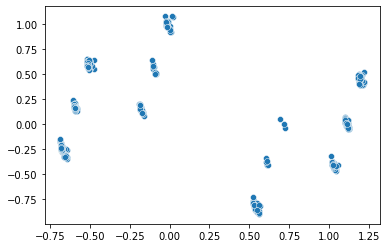

In [57]:
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1])

As PCA preserves distance, the image shows that there are definite clusters distanct from eachother.  Although nothing can be inferred, a cluster number of at least 6 seems reasonable, 12 seems ideal with this visualization.

In [58]:
umap2 = UMAP(n_components=2)

In [59]:
X_initial_2d = umap2.fit_transform(X_initial)

<AxesSubplot:>

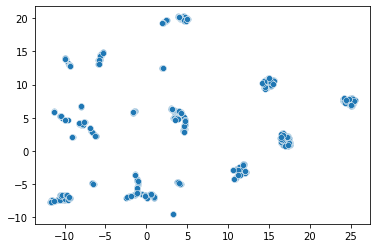

In [60]:
sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1])

Although nothing can be inferred, there appear to be ten or more clusters.

In [61]:
df['x'] = X_initial_2d[:,0]
df['y'] = X_initial_2d[:,1]

# Clustering all data using KMeans

* use inertia to find the best k or k values
* Check consistency
* Look at silhouette score

In [62]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))


<AxesSubplot:>

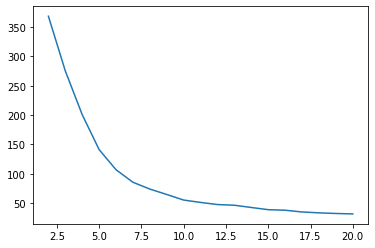

In [63]:
sns.lineplot(x=results[0],y=results[1])

It is hard to see an elbow.  I would say 6 or 9.

Checking for a more pronounced elbow by adjusting other parameters of the k means algorithm

<AxesSubplot:>

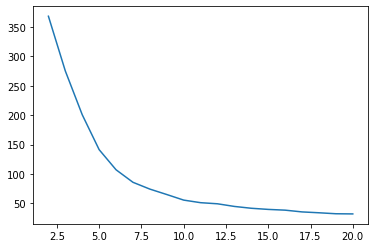

In [64]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='full')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

<AxesSubplot:>

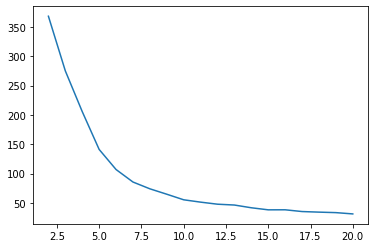

In [65]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='elkan')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

The three graphs look similar.  I will choose 9 for kmeans

In [66]:
kmeans = KMeans(n_clusters=9)
df['kmeans_labels'] = kmeans.fit_predict(X_initial)

Visualizing the data

<AxesSubplot:xlabel='x', ylabel='y'>

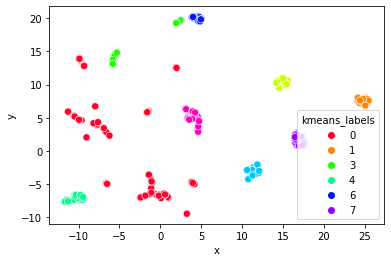

In [67]:
sns.scatterplot(x='x',y='y', hue='kmeans_labels', data=df, palette='gist_rainbow', s=50)

Kmeans does seems to seperate groups nicely

In [68]:
silhouette_score(X_initial, df['kmeans_labels'])

0.5564717108991618

A 0.5 silhouette_score is not bad.  Now I am going to check for consistency using visualizations.

In [69]:
X1, X2 = train_test_split(df, test_size=0.5)
X1 = X1.index
X2 = X2.index

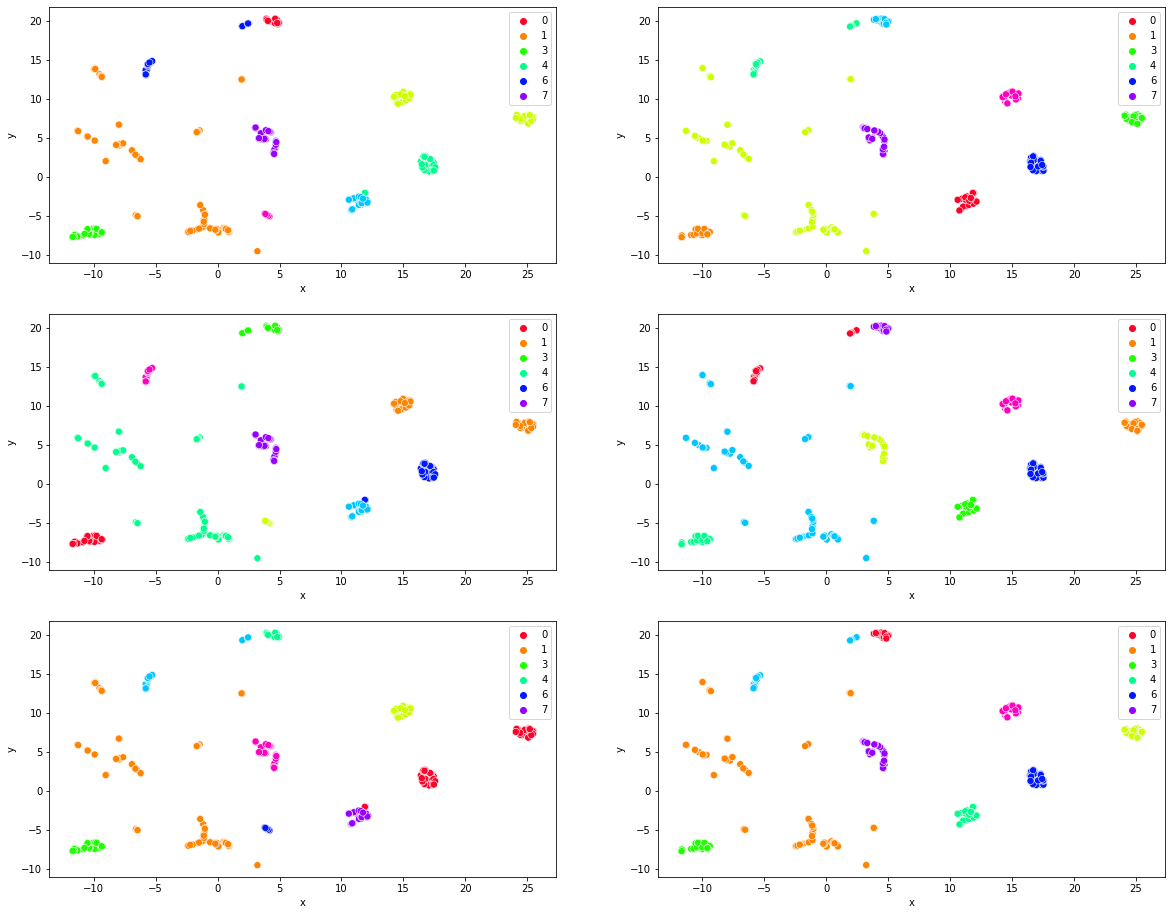

In [70]:
seed = [123,456,789]
fig, ax = plt.subplots(3,2, figsize=(20,16))
for n in range(3):
    labels = kmeans.fit_predict(X_initial[X1])
    sns.scatterplot(x=df['x'][X1],y=df['y'][X1], hue=labels, palette='gist_rainbow', s=50, ax=ax[n,0])
    labels = kmeans.fit_predict(X_initial[X2])
    sns.scatterplot(x=df['x'][X2],y=df['y'][X2], hue=labels, palette='gist_rainbow', s=50, ax=ax[n,1])

    
    

From the graphs above there is some inconsistency as some clusters are combined in one picture but not another.

# Hierarchal Clustering

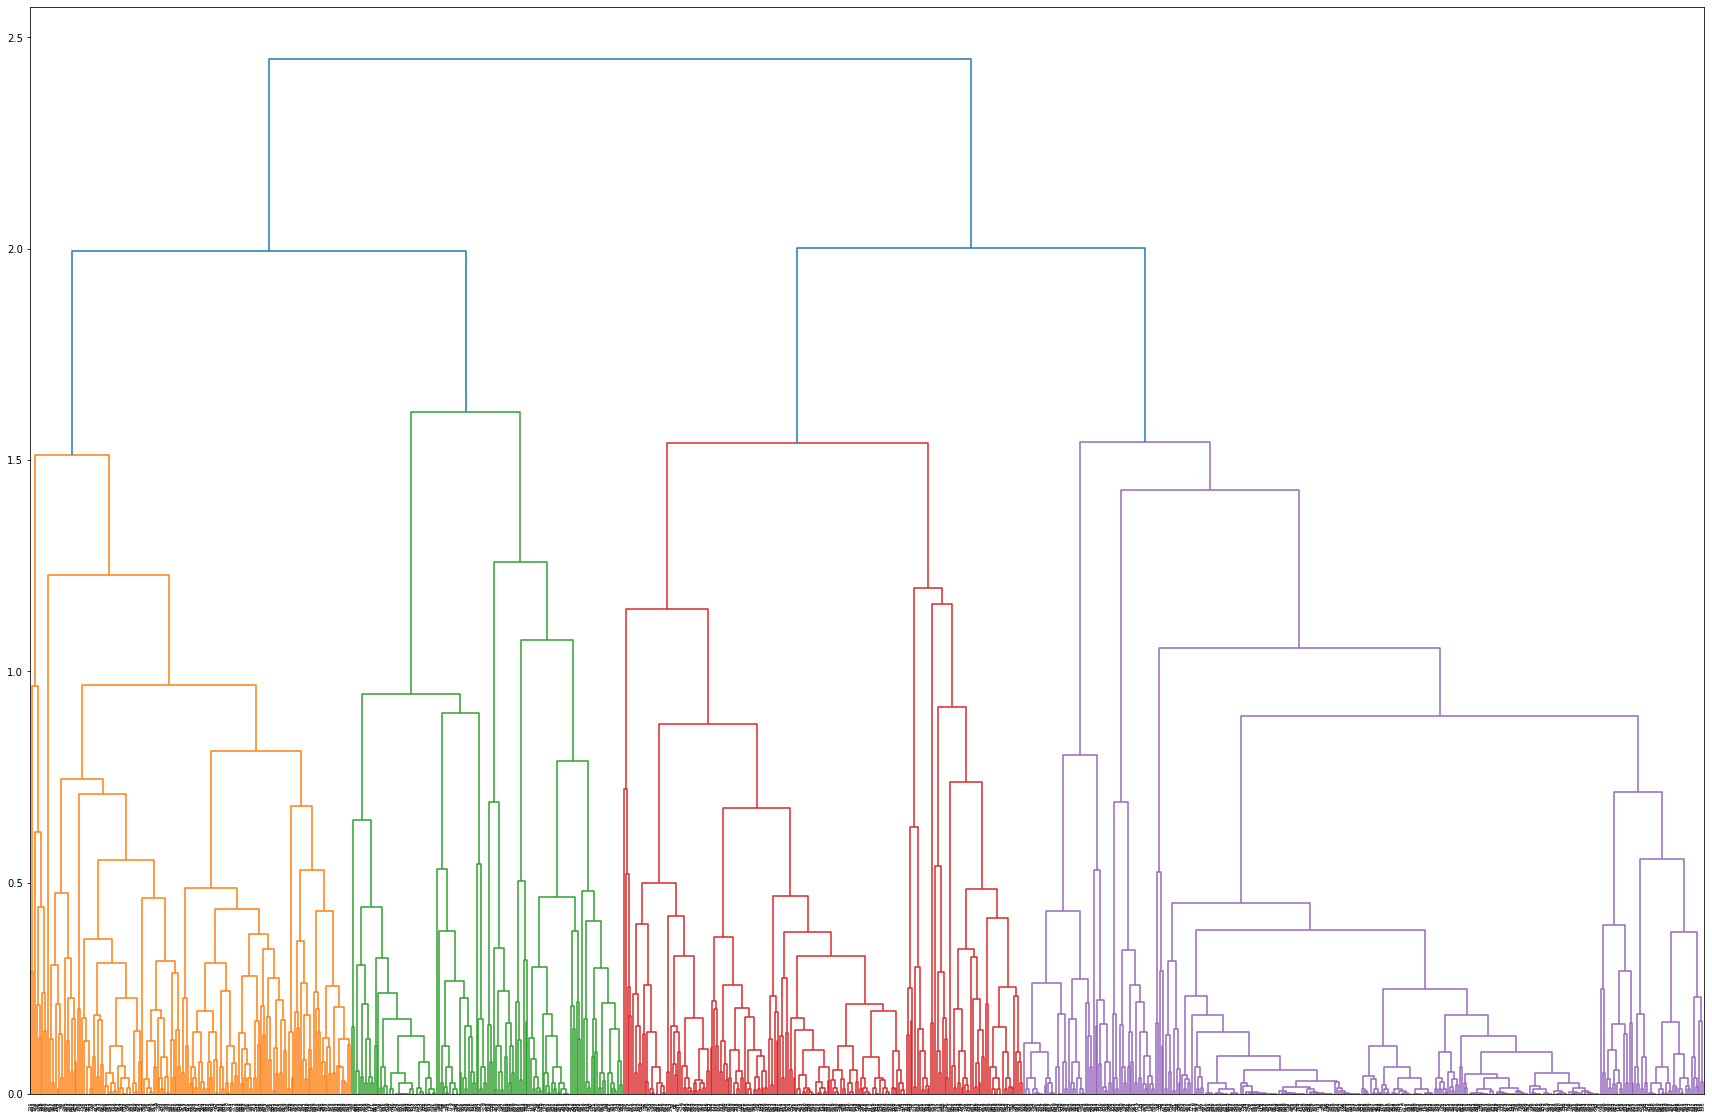

In [71]:
plt.figure(figsize=(30,20))
dendrogram(linkage(X_initial, method='complete'))
plt.show()

In order to incorporate all the various colors, you will want the number of clusters to be at least 8. I picked a y of approximately 12 as a cutoff which makes 9 clusters.

In [72]:
agg = AgglomerativeClustering(n_clusters=9)

In [73]:
agg.fit(X_initial)

AgglomerativeClustering(n_clusters=9)

In [74]:
df['agg_labels'] = agg.fit_predict(X_initial)

In [75]:
silhouette_score(X_initial, df['agg_labels'])

0.5842505171590076

Now I am going to try other settings for agglomerative clustering and see which has the best silouette score.

In [76]:
agg2 = AgglomerativeClustering(compute_full_tree=True, distance_threshold=5, n_clusters=None)

Using this the number of clusters id determined by the algorithm, howeveer distance_threshold would need to be tuned.

In [77]:
silhouette_score(X_initial, agg2.fit_predict(X_initial))

0.5700730275301739

In [78]:
agg2.n_clusters_

7

With computing a full tree and a distance of 5, the algorithm came up with 7 clusters with a slightly less silhouette score.  Now I am going to try to change the distance metric of the first algorithm to Manhattan and the linkage method to complete to see what changes.

In [79]:
agg3 = AgglomerativeClustering(n_clusters=9, linkage='complete', affinity='manhattan')

In [80]:
silhouette_score(X_initial, agg3.fit_predict(X_initial))

0.5324695305241087

The silhouette score slightly decreased.  If this were a capstone or personal project, I would play with this more but because it is only an assignment I'm moving on to DBSCAN

# Clustering using DBSCAN

In [81]:
db = DBSCAN()

In [82]:
df['dbscan_labels']=db.fit_predict(X_initial)

In [83]:
# now get the silhouette score for those that are not outlers
silhouette_score(X_initial[df['dbscan_labels']!=-1],df[df['dbscan_labels']!=-1]['dbscan_labels'])

0.545835073969786

In [84]:
df['dbscan_labels'].max()

9

DBSCAN chose 9 clusters which the elbow method originally also suggested. The silhouette score is slightly lower than agglomerative clustering.

# Comparing clusters

## How they are grouped

In [85]:
stats = {}
for n in range(9):
    #stats['mean_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].mean()
    stats['std_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].std()
(pd.DataFrame(stats)).transpose()
    

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
std_cluster_0,0.0,0.000000,11.797449,1.362608,0.632890,11.048677,0.0,0.0,4.749520,7.288892,0.0,1.608939,0.000000
std_cluster_1,0.0,0.000000,12.763295,0.653704,0.851864,11.140937,0.0,0.0,0.476933,0.374738,0.0,0.000000,0.000000
std_cluster_2,0.0,0.000000,10.940216,0.888106,0.919277,5.984714,0.0,0.0,0.456491,0.457009,0.0,0.000000,0.000000
std_cluster_3,0.0,0.438776,12.735524,0.708011,0.636008,14.230985,0.0,0.0,3.448946,2.457451,0.0,0.877552,0.877552
std_cluster_4,0.0,0.000000,13.661642,0.553372,0.656999,60.052545,0.0,0.0,0.781402,0.359897,0.0,0.000000,0.000000
std_cluster_5,0.0,0.450309,13.856058,1.814635,1.391442,24.821287,0.0,0.0,0.494586,0.656817,0.0,0.000000,1.595131
std_cluster_6,0.0,0.147442,14.646618,0.531610,0.662305,100.408695,0.0,0.0,0.483301,0.232182,0.0,0.000000,1.651379
std_cluster_7,0.0,0.000000,12.870416,0.671048,0.701472,74.738897,0.0,0.0,0.380910,0.611842,0.0,0.000000,0.209657
std_cluster_8,0.0,0.000000,12.019198,0.551610,0.436436,15.720548,0.0,0.0,0.601907,1.088943,0.0,0.000000,0.000000


In [86]:
stats2 = {}
for n in range(9):
    stats2['std_cluster_{}'.format(n)] = df[df['agg_labels']==n].std()
(pd.DataFrame(stats2)).transpose()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
std_cluster_0,0.0,0.501720,12.417150,0.778674,0.886446,10.152416,0.0,0.0,4.979208,1.424060,0.501720,0.0,1.003440
std_cluster_1,0.0,0.450309,13.856058,1.814635,1.391442,24.821287,0.0,0.0,0.494586,0.656817,0.000000,0.0,1.595131
std_cluster_2,0.0,0.000000,10.747688,0.446412,0.507008,6.084348,0.0,0.0,4.400430,7.421359,0.000000,0.0,0.000000
std_cluster_3,0.0,0.000000,13.661642,0.553372,0.656999,60.052545,0.0,0.0,0.781402,0.359897,0.000000,0.0,0.000000
std_cluster_4,0.0,0.449749,17.790303,0.559519,0.688540,89.312557,0.0,0.0,1.094392,0.304131,1.323425,0.0,1.445374
std_cluster_5,0.0,0.000000,12.870416,0.671048,0.701472,74.738897,0.0,0.0,0.380910,0.611842,0.000000,0.0,0.209657
std_cluster_6,0.0,0.000000,11.365395,0.730592,0.586622,15.232388,0.0,0.0,0.174376,0.611883,0.000000,0.0,0.000000
std_cluster_7,0.0,0.000000,12.019198,0.551610,0.436436,15.720548,0.0,0.0,0.601907,1.088943,0.000000,0.0,0.000000
std_cluster_8,0.0,0.000000,5.832646,1.663370,0.510754,15.285887,0.0,0.0,0.126669,0.120406,0.000000,0.0,0.000000


In [89]:
stats3 = {}
for n in range(9):
    stats3['std_cluster_{}'.format(n)] = df[df['dbscan_labels']==n].std()
(pd.DataFrame(stats3)).transpose()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
std_cluster_0,0.0,0.424637,12.092916,1.224283,0.592876,12.664847,0.0,0.0,5.242880,6.665740,3.397093,2.384289,0.0
std_cluster_1,0.0,0.000000,12.942377,0.672261,0.703922,61.422775,0.0,0.0,0.382896,0.615168,0.000000,0.000000,0.0
std_cluster_2,0.0,0.000000,10.940216,0.888106,0.919277,5.984714,0.0,0.0,0.456491,0.457009,0.000000,0.000000,0.0
std_cluster_3,0.0,0.000000,13.661642,0.553372,0.656999,60.052545,0.0,0.0,0.781402,0.359897,0.000000,0.000000,0.0
std_cluster_4,0.0,0.000000,12.763295,0.653704,0.851864,11.140937,0.0,0.0,0.476933,0.374738,0.000000,0.000000,0.0
std_cluster_5,0.0,0.000000,13.262687,1.902093,1.435562,14.572275,0.0,0.0,0.494968,0.563030,0.000000,0.000000,0.0
std_cluster_6,0.0,0.000000,18.539658,0.624264,0.701888,9.832542,0.0,0.0,0.238747,0.182441,0.727607,0.000000,0.0
std_cluster_7,0.0,0.000000,14.659832,0.540702,0.673826,34.049120,0.0,0.0,0.396249,0.224724,0.000000,0.000000,0.0
std_cluster_8,0.0,0.000000,11.365395,0.730592,0.586622,15.232388,0.0,0.0,0.174376,0.611883,0.000000,0.000000,0.0


By looking at the standard deviations of the clusers, as expected people were groupd by whether they survived and their sex, as well as their passenger class for some clusters. 

## Comparing agglomerative clusters

In [91]:
df[df['agg_labels']==0][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0,142.0
mean,1.0,2.507042,24.570423,0.492958,0.570423,17.307571,1.0,0.0
std,0.0,0.501720,12.417150,0.778674,0.886446,10.152416,0.0,0.0
min,1.0,2.000000,0.750000,0.000000,0.000000,7.225000,1.0,0.0
25%,1.0,2.000000,18.000000,0.000000,0.000000,9.409375,1.0,0.0
50%,1.0,3.000000,24.000000,0.000000,0.000000,13.825000,1.0,0.0
75%,1.0,3.000000,31.750000,1.000000,1.000000,23.187500,1.0,0.0
max,1.0,3.000000,63.000000,4.000000,5.000000,65.000000,1.0,0.0


Cluster 0 consisted of 142 females whom survived.

In [92]:
df[df['agg_labels']==1][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81.0
mean,0.0,2.851852,24.419753,1.209877,1.037037,23.024385,1.0,0.0
std,0.0,0.450309,13.856058,1.814635,1.391442,24.821287,0.0,0.0
min,0.0,1.000000,2.000000,0.000000,0.000000,6.750000,1.0,0.0
25%,0.0,3.000000,14.500000,0.000000,0.000000,8.850000,1.0,0.0
50%,0.0,3.000000,22.000000,1.000000,0.000000,15.245800,1.0,0.0
75%,0.0,3.000000,32.000000,1.000000,2.000000,27.900000,1.0,0.0
max,0.0,3.000000,62.000000,8.000000,6.000000,151.550000,1.0,0.0


Cluster 1 consists of 81 females whom did not survive.

In [93]:
df[df['agg_labels']==2][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,273.0,273.0,273.000000,273.000000,273.000000,273.000000,273.0,273.0
mean,0.0,3.0,28.732601,0.179487,0.106227,9.804240,0.0,1.0
std,0.0,0.0,10.747688,0.446412,0.507008,6.084348,0.0,0.0
min,0.0,3.0,11.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.0,3.0,21.000000,0.000000,0.000000,7.725000,0.0,1.0
50%,0.0,3.0,26.000000,0.000000,0.000000,7.895800,0.0,1.0
75%,0.0,3.0,34.000000,0.000000,0.000000,8.662500,0.0,1.0
max,0.0,3.0,74.000000,2.000000,5.000000,56.495800,0.0,1.0


Cluster 2 consists of 273 males from the third class whom did not survive.

In [94]:
df[df['agg_labels']==3][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,77.0,77.0,77.000000,77.000000,77.000000,77.000000,77.0,77.0
mean,0.0,1.0,44.292208,0.272727,0.259740,62.894910,0.0,1.0
std,0.0,0.0,13.661642,0.553372,0.656999,60.052545,0.0,0.0
min,0.0,1.0,18.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.0,1.0,36.000000,0.000000,0.000000,27.720800,0.0,1.0
50%,0.0,1.0,45.000000,0.000000,0.000000,42.400000,0.0,1.0
75%,0.0,1.0,55.000000,0.000000,0.000000,77.287500,0.0,1.0
max,0.0,1.0,71.000000,3.000000,4.000000,263.000000,0.0,1.0


Cluster 3 consists of 77 males from the first class whom did not survive.  

In [95]:
df[df['agg_labels']==4][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,62.0,62.000000,62.000000,62.000000,62.000000,62.000000,62.0,62.0
mean,1.0,1.274194,31.358871,0.419355,0.403226,59.956389,0.0,1.0
std,0.0,0.449749,17.790303,0.559519,0.688540,89.312557,0.0,0.0
min,1.0,1.000000,0.670000,0.000000,0.000000,10.500000,0.0,1.0
25%,1.0,1.000000,23.500000,0.000000,0.000000,26.312500,0.0,1.0
50%,1.0,1.000000,34.000000,0.000000,0.000000,30.500000,0.0,1.0
75%,1.0,2.000000,44.250000,1.000000,1.000000,56.982300,0.0,1.0
max,1.0,2.000000,80.000000,2.000000,2.000000,512.329200,0.0,1.0


In [96]:
df[df['agg_labels']==5][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,91.0,91.0,91.000000,91.000000,91.000000,91.000000,91.0,91.0
mean,1.0,1.0,35.571429,0.549451,0.428571,105.978159,1.0,0.0
std,0.0,0.0,12.870416,0.671048,0.701472,74.738897,0.0,0.0
min,1.0,1.0,14.000000,0.000000,0.000000,25.929200,1.0,0.0
25%,1.0,1.0,24.000000,0.000000,0.000000,57.489600,1.0,0.0
50%,1.0,1.0,35.000000,0.000000,0.000000,82.170800,1.0,0.0
75%,1.0,1.0,44.500000,1.000000,1.000000,134.075000,1.0,0.0
max,1.0,1.0,63.000000,3.000000,2.000000,512.329200,1.0,0.0


In [97]:
df[df['agg_labels']==6][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,47.0,47.0,47.000000,47.000000,47.000000,47.000000,47.0,47.0
mean,1.0,3.0,22.242979,0.340426,0.297872,15.579696,0.0,1.0
std,0.0,0.0,11.365395,0.730592,0.586622,15.232388,0.0,0.0
min,1.0,3.0,0.420000,0.000000,0.000000,0.000000,0.0,1.0
25%,1.0,3.0,17.000000,0.000000,0.000000,7.825000,0.0,1.0
50%,1.0,3.0,25.000000,0.000000,0.000000,8.050000,0.0,1.0
75%,1.0,3.0,29.500000,0.500000,0.000000,15.820850,0.0,1.0
max,1.0,3.0,45.000000,4.000000,2.000000,56.495800,0.0,1.0


In [98]:
df[df['agg_labels']==7][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,91.0,91.0,91.000000,91.000000,91.000000,91.000000,91.0,91.0
mean,0.0,2.0,33.000000,0.307692,0.142857,19.488965,0.0,1.0
std,0.0,0.0,12.019198,0.551610,0.436436,15.720548,0.0,0.0
min,0.0,2.0,16.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.0,2.0,24.000000,0.000000,0.000000,11.500000,0.0,1.0
50%,0.0,2.0,30.000000,0.000000,0.000000,13.000000,0.0,1.0
75%,0.0,2.0,39.000000,1.000000,0.000000,26.000000,0.0,1.0
max,0.0,2.0,70.000000,2.000000,2.000000,73.500000,0.0,1.0


Cluster 7 is different from the other clusters in that it only contained adults.

In [99]:
df[df['agg_labels']==8][column_names].describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
count,23.0,23.0,23.000000,23.000000,23.000000,23.000000,23.0,23.0
mean,0.0,3.0,8.260870,4.695652,1.521739,41.119204,0.0,1.0
std,0.0,0.0,5.832646,1.663370,0.510754,15.285887,0.0,0.0
min,0.0,3.0,1.000000,3.000000,1.000000,21.075000,0.0,1.0
25%,0.0,3.0,4.000000,4.000000,1.000000,29.125000,0.0,1.0
50%,0.0,3.0,7.000000,4.000000,2.000000,39.687500,0.0,1.0
75%,0.0,3.0,12.500000,5.000000,2.000000,46.900000,0.0,1.0
max,0.0,3.0,20.000000,8.000000,2.000000,69.550000,0.0,1.0


Cluster 8 is different from the other clusters in that every member of the cluster had other family members aboard.

# Looking at what DBSCAN calls outliers

In [88]:
df[df['dbscan_labels']==-1]

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
176,0,1,50.0,0,0,28.7125,1,0,11.888103,-2.020007,5,1,-1
257,1,1,35.0,0,0,512.3292,1,0,16.896666,1.526692,7,5,-1
295,0,1,2.0,1,2,151.5500,1,0,11.927534,-2.037430,5,1,-1
495,0,1,25.0,1,2,151.5500,1,0,11.949205,-2.030846,5,1,-1
676,1,1,36.0,0,1,512.3292,0,1,4.569621,19.597073,6,4,-1
733,1,1,35.0,0,0,512.3292,0,1,4.666489,19.666883,6,4,-1


What is interesting is looking at the outliers for the data as predicted by dbscan and evaluate what makes them outliers.  For example, #176, #295, and #495 are first class females who did not survive.